In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [3]:
print(sample_submission.head())
print()
print()
print(items.shape)
print(items.head())
print()
print(item_categories.shape)
print(item_categories.head())
print()
print(shops.shape)
print(shops.head())
print()
print(sales_train.shape)
print(sales_train.head())
print()
print(test.shape)
print(test.head())

   ID  item_cnt_month
0   0             0.5
1   1             0.5
2   2             0.5
3   3             0.5
4   4             0.5


(22170, 3)
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  

(84, 2)
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

(60, 2)
                        shop_name  shop_id
0

In [4]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)
transactions.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,02.01.2013,0,59,22154,999.00,1.0,2,1,2013
1,03.01.2013,0,25,2552,899.00,1.0,3,1,2013
2,05.01.2013,0,25,2552,899.00,-1.0,5,1,2013
3,06.01.2013,0,25,2554,1709.05,1.0,6,1,2013
4,15.01.2013,0,25,2555,1099.00,1.0,15,1,2013


In [5]:
item_cnt_month = transactions.groupby(['shop_id', 'item_id', 'month', 'year'])['item_cnt_day'].sum().reset_index(name ='item_cnt_month')
item_cnt_month.head()
item_cnt_month.shape

(1609124, 5)

In [6]:
month_year = set(list(zip(item_cnt_month.month, item_cnt_month.year)))
month_year

{(1, 2013),
 (1, 2014),
 (1, 2015),
 (2, 2013),
 (2, 2014),
 (2, 2015),
 (3, 2013),
 (3, 2014),
 (3, 2015),
 (4, 2013),
 (4, 2014),
 (4, 2015),
 (5, 2013),
 (5, 2014),
 (5, 2015),
 (6, 2013),
 (6, 2014),
 (6, 2015),
 (7, 2013),
 (7, 2014),
 (7, 2015),
 (8, 2013),
 (8, 2014),
 (8, 2015),
 (9, 2013),
 (9, 2014),
 (9, 2015),
 (10, 2013),
 (10, 2014),
 (10, 2015),
 (11, 2013),
 (11, 2014),
 (12, 2013),
 (12, 2014)}

In [7]:
years = list(set([y for (m,y) in month_year]))
years.sort()
months = list(range(1,13))

date_to_int = {}

i = 1
for year in years:
    for month in months:
        date_to_int[(month,year)] = i
        i+=1

In [8]:
date_to_int

{(1, 2013): 1,
 (2, 2013): 2,
 (3, 2013): 3,
 (4, 2013): 4,
 (5, 2013): 5,
 (6, 2013): 6,
 (7, 2013): 7,
 (8, 2013): 8,
 (9, 2013): 9,
 (10, 2013): 10,
 (11, 2013): 11,
 (12, 2013): 12,
 (1, 2014): 13,
 (2, 2014): 14,
 (3, 2014): 15,
 (4, 2014): 16,
 (5, 2014): 17,
 (6, 2014): 18,
 (7, 2014): 19,
 (8, 2014): 20,
 (9, 2014): 21,
 (10, 2014): 22,
 (11, 2014): 23,
 (12, 2014): 24,
 (1, 2015): 25,
 (2, 2015): 26,
 (3, 2015): 27,
 (4, 2015): 28,
 (5, 2015): 29,
 (6, 2015): 30,
 (7, 2015): 31,
 (8, 2015): 32,
 (9, 2015): 33,
 (10, 2015): 34,
 (11, 2015): 35,
 (12, 2015): 36}

In [9]:
def get_date_int(row):
    return date_to_int[(row['month'], row['year'])]

item_cnt_month['date_counter'] = item_cnt_month.apply(get_date_int, axis=1)

In [10]:
item_cnt_month.sample(10)

,shop_id,item_id,month,year,item_cnt_month,date_counter
573918,26,1408,8,2013,2.0,8
1282997,51,9281,3,2013,2.0,3
409694,21,12363,9,2015,1.0,33
1481839,56,19636,1,2014,1.0,13
670777,28,5976,4,2014,1.0,16
1266070,50,18584,4,2014,1.0,16
713257,28,20222,9,2013,1.0,9
802605,31,6661,3,2013,6.0,3
1538897,57,19124,9,2014,1.0,21
1041044,42,11223,5,2014,1.0,17


In [11]:
w_cat_ids = item_cnt_month.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids['shop_cat_tuple'] = w_cat_ids.apply(lambda row: (row.shop_id, row.item_category_id),axis=1)
w_cat_ids.head()

,shop_id,month,year,item_cnt_month,date_counter,item_name,item_category_id,shop_cat_tuple
item_id,,,,,,,,
0,54,9,2014,1.0,21,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"(54, 40)"
1,55,4,2014,2.0,16,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,7,2014,1.0,19,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,8,2014,1.0,20,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,9,2014,1.0,21,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"


In [12]:
def get_biggest_shops(num=10):
    shop_cnt_month = item_cnt_month.groupby(['shop_id'])['item_cnt_month'].sum().reset_index(name ='total_item_cnt')
    shop_cnt_month = shop_cnt_month.sort_values(by='total_item_cnt', ascending=0)
    return list(shop_cnt_month.iloc[0:num,0])

def get_biggest_categories_for_shop(shop_id, num=10):
    shop = w_cat_ids.loc[w_cat_ids['shop_id'] == shop_id]
    shop_cat_id = shop.groupby(['date_counter', 'item_category_id'])['item_cnt_month'].sum().reset_index(name ='item_cnt')
    by_cat = shop_cat_id.groupby(['item_category_id'])['item_cnt'].sum().reset_index(name ='total_item_cnt').sort_values(by=['total_item_cnt'], ascending=False)
    return list(by_cat.iloc[0:num,0])

def get_shop_w_one_cat(shop_id, cat_id):
    shop = w_cat_ids.loc[(w_cat_ids['shop_id'] == shop_id) & (w_cat_ids['item_category_id'] == cat_id)]
    shop= shop.groupby(['date_counter','item_category_id'])['item_cnt_month'].sum().reset_index(name ='item_cnt')
    shop = shop[['date_counter', 'item_cnt', 'item_category_id']]
    return shop

def get_shop_w_all_cats(shop_id):
    shop = w_cat_ids.loc[(w_cat_ids['shop_id'] == shop_id)]
    shop= shop.groupby(['date_counter'])['item_cnt_month'].sum().reset_index(name ='item_cnt')
    shop = shop[['date_counter', 'item_cnt']]
    return shop

In [13]:
get_biggest_shops()

[31, 25, 54, 28, 42, 57, 27, 6, 58, 46]

In [14]:
print(get_biggest_shops())
print(get_biggest_categories_for_shop(31))

[31, 25, 54, 28, 42, 57, 27, 6, 58, 46]
[40, 30, 55, 71, 37, 19, 28, 23, 63, 20]


In [15]:
poly_degree = 10

def show_polynomials_for_shop_biggest_categories(shop_id):
    categories = get_biggest_categories_for_shop(shop_id)
    
    for categorie in categories:
        shop = get_shop_w_one_cat(shop_id, categorie)

        datax = shop.date_counter.values
        datay = shop.item_cnt.values

        z = np.polyfit(datax,datay, poly_degree) 
        p = np.poly1d(z)

        shop['poly'] = shop['date_counter'].apply(lambda x: p(x))

        sns.set()
        fig, ax = plt.subplots()
        shop.plot(x='date_counter', y='item_cnt', ax=ax, legend=False, figsize=(15,7))
        shop.plot(x='date_counter', y='poly', ax=ax, legend=False, figsize=(15,7))

#p(15)

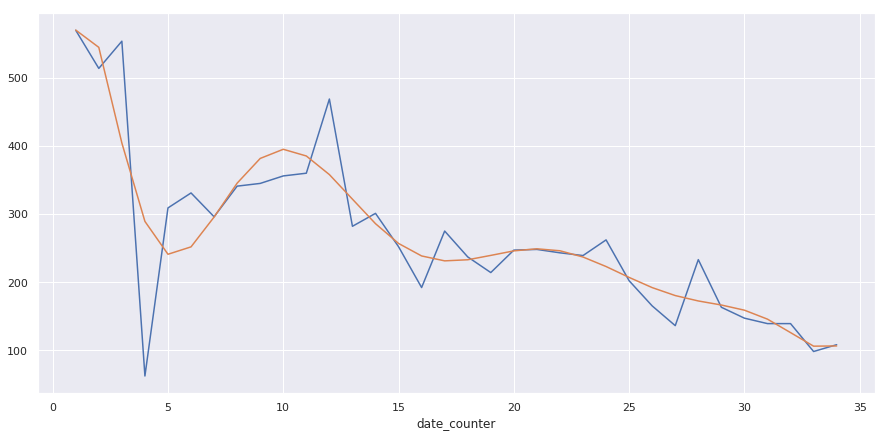

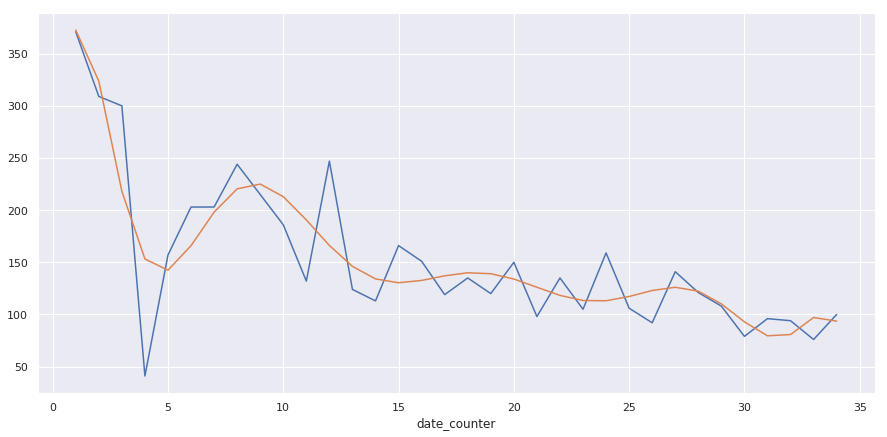

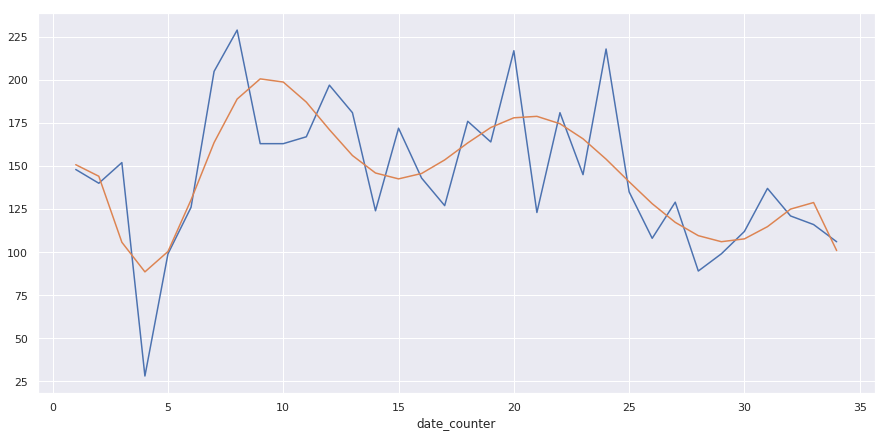

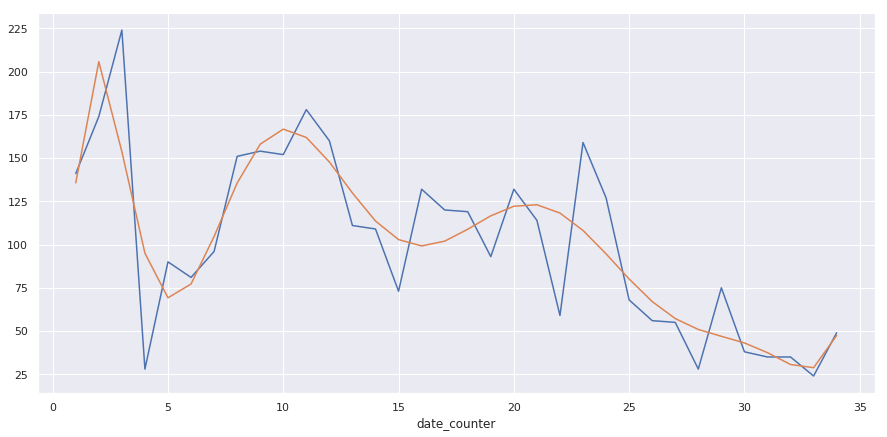

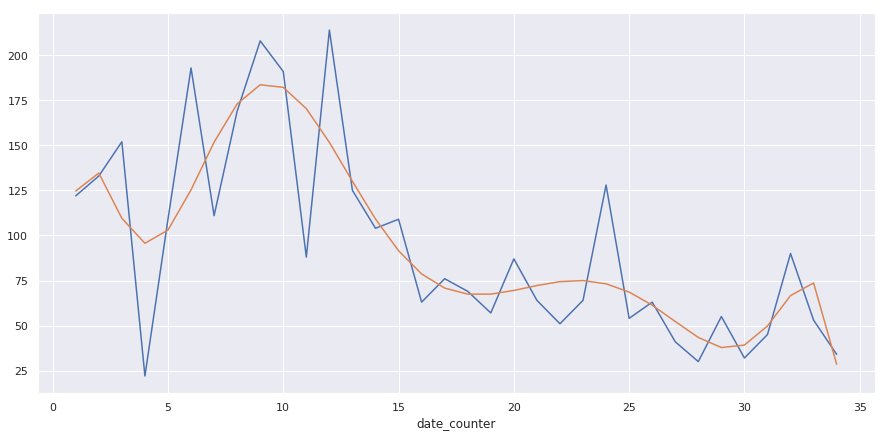

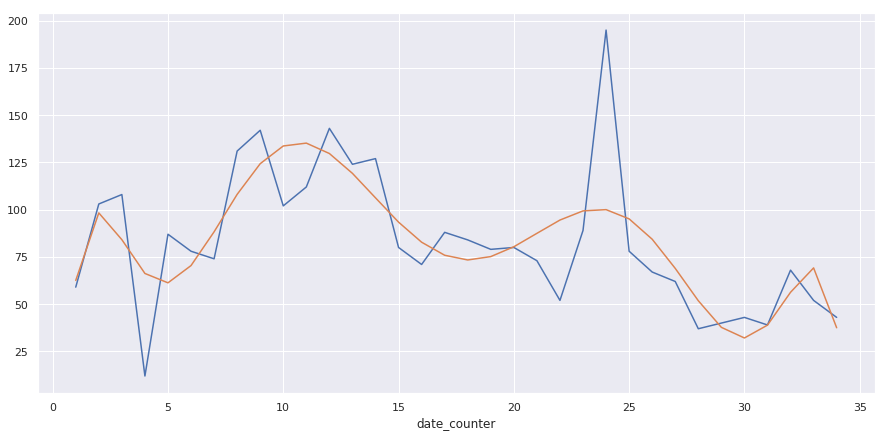

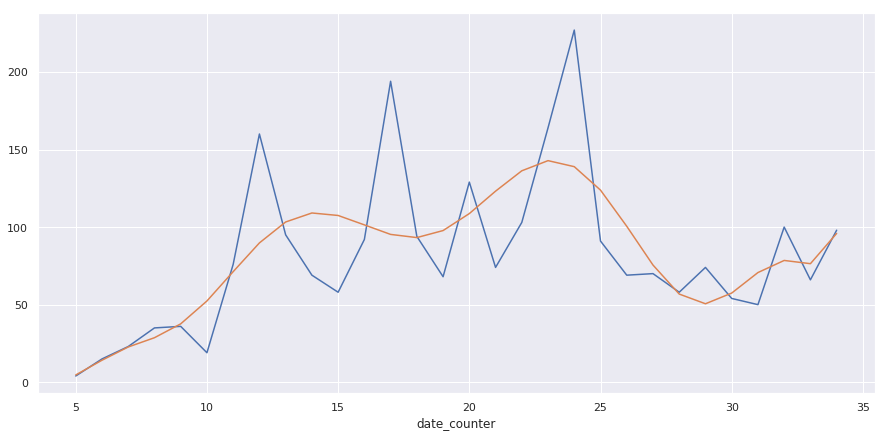

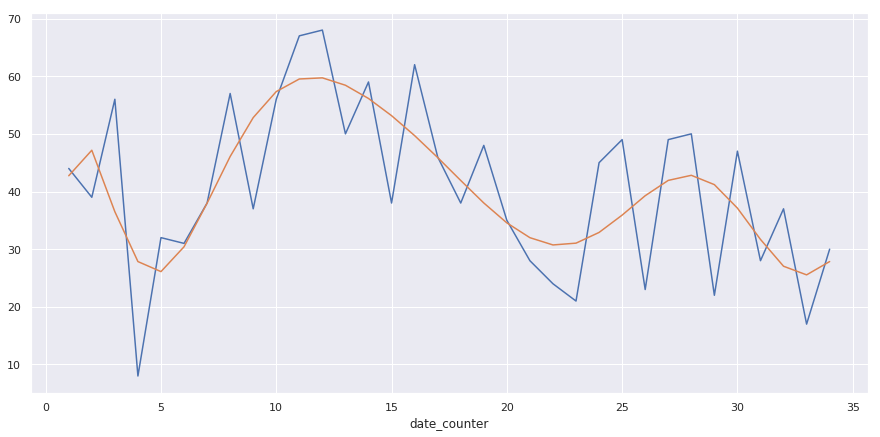

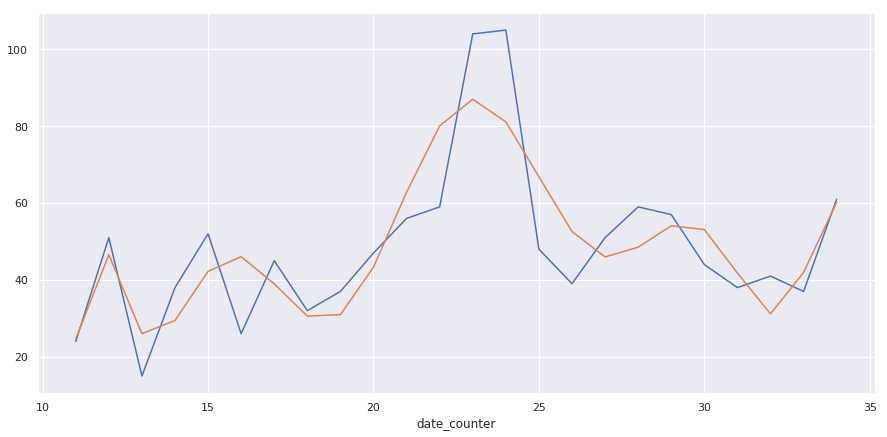

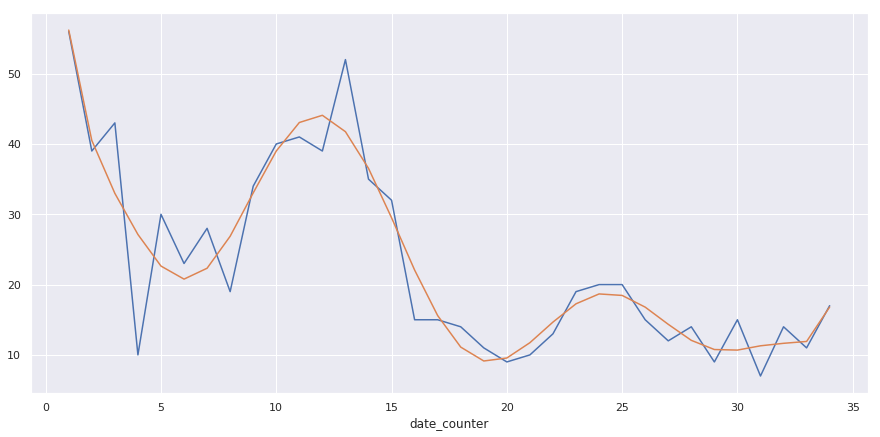

In [16]:
show_polynomials_for_shop_biggest_categories(4)

In [17]:
w_cat_ids.head()

,shop_id,month,year,item_cnt_month,date_counter,item_name,item_category_id,shop_cat_tuple
item_id,,,,,,,,
0,54,9,2014,1.0,21,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"(54, 40)"
1,55,4,2014,2.0,16,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,7,2014,1.0,19,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,8,2014,1.0,20,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,9,2014,1.0,21,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"


In [18]:
cat_count = w_cat_ids.groupby(['shop_id'])['item_category_id'].unique().reset_index(name ='unique_cat_ids')
cat_count['cnt'] = cat_count['unique_cat_ids'].apply(lambda r: len(r))
cat_count['cnt'].sum()

3271

In [19]:
cat_count.head()

,shop_id,unique_cat_ids,cnt
0,0,"[40, 37, 57, 43, 45, 49, 73, 77, 30, 55, 67, 5...",48
1,1,"[19, 23, 40, 37, 49, 73, 77, 30, 67, 55, 29, 2...",41
2,2,"[19, 40, 37, 57, 49, 45, 73, 77, 23, 30, 55, 3...",59
3,3,"[19, 30, 40, 37, 43, 45, 49, 73, 77, 23, 55, 3...",58
4,4,"[19, 30, 23, 40, 37, 41, 57, 45, 49, 73, 77, 5...",61


In [20]:
test_w_cat_id = test.set_index('item_id').join(items.set_index('item_id'))

In [21]:
def is_in_test(shop_id, cat_id):
    return len(test_w_cat_id.loc[(test_w_cat_id.shop_id == shop_id) & (test_w_cat_id.item_category_id == cat_id)]) > 0

In [22]:
is_in_test(31, 40)

True

In [23]:
in_test = {}

for index, row in cat_count.iterrows():
    for cat_id in row['unique_cat_ids']:
        shop_id = row[0]
        if is_in_test(shop_id, cat_id):
            in_test[(shop_id, cat_id)] = True
        else:
            in_test[(shop_id, cat_id)] = False
            
in_test

{(0, 40): False,
 (0, 37): False,
 (0, 57): False,
 (0, 43): False,
 (0, 45): False,
 (0, 49): False,
 (0, 73): False,
 (0, 77): False,
 (0, 30): False,
 (0, 55): False,
 (0, 67): False,
 (0, 59): False,
 (0, 75): False,
 (0, 29): False,
 (0, 28): False,
 (0, 19): False,
 (0, 23): False,
 (0, 22): False,
 (0, 21): False,
 (0, 4): False,
 (0, 60): False,
 (0, 62): False,
 (0, 56): False,
 (0, 15): False,
 (0, 2): False,
 (0, 5): False,
 (0, 1): False,
 (0, 35): False,
 (0, 25): False,
 (0, 14): False,
 (0, 13): False,
 (0, 11): False,
 (0, 69): False,
 (0, 6): False,
 (0, 33): False,
 (0, 38): False,
 (0, 41): False,
 (0, 65): False,
 (0, 63): False,
 (0, 70): False,
 (0, 3): False,
 (0, 64): False,
 (0, 82): False,
 (0, 81): False,
 (0, 0): False,
 (0, 72): False,
 (0, 71): False,
 (0, 83): False,
 (1, 19): False,
 (1, 23): False,
 (1, 40): False,
 (1, 37): False,
 (1, 49): False,
 (1, 73): False,
 (1, 77): False,
 (1, 30): False,
 (1, 67): False,
 (1, 55): False,
 (1, 29): False,
 (1,

In [24]:
test_w_cat_id.head()

,ID,shop_id,item_name,item_category_id
item_id,,,,
30,2587,5,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,7687,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,12787,6,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,17887,3,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,22987,2,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40


In [25]:
poly_degree = 10

poly1d_cache = {}

#get poly convenience function for a shop
def get_p_for_shop(shop):
    x = shop.date_counter.values
    y = np.clip(shop.item_cnt.values, 0 ,20)

    z = np.polyfit(x,y, poly_degree) 
    p = np.poly1d(z)
    return p

for (shop_id, cat_id), in_test_bool in in_test.items():
    #build the default all categories model for missing tuples
    if shop_id not in poly1d_cache:
        shop = get_shop_w_all_cats(shop_id)
        p = get_p_for_shop(shop)
        poly1d_cache[shop_id] = p
    #if cached already skip
    if (shop_id, cat_id) in poly1d_cache:
        continue
    #get the shop
    shop = get_shop_w_one_cat(shop_id, cat_id)
    p = get_p_for_shop(shop)
    poly1d_cache[(shop_id, cat_id)] = p

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: RankWarning: Polyfit may be poorly conditioned
  # Remove the CWD from sys.path while we load stuff.
/opt

In [26]:
len(poly1d_cache)

3331

In [27]:
test_w_cat_id.head()

,ID,shop_id,item_name,item_category_id
item_id,,,,
30,2587,5,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,7687,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,12787,6,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,17887,3,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40
30,22987,2,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40


In [28]:
test_w_cat_id['shop_cat_tuple'] = test_w_cat_id.apply (lambda row: (row.shop_id, row.item_category_id),axis=1)
test_w_cat_id.head()

,ID,shop_id,item_name,item_category_id,shop_cat_tuple
item_id,,,,,
30,2587,5,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"(5, 40)"
30,7687,4,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"(4, 40)"
30,12787,6,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"(6, 40)"
30,17887,3,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"(3, 40)"
30,22987,2,007: КООРДИНАТЫ «СКАЙФОЛЛ»,40,"(2, 40)"


In [29]:
#nov 15 = 35
date_int_target = 35


def get_pred(shop_cat_tuple):
    if shop_cat_tuple not in poly1d_cache:
        #use the default all categories model
        p = poly1d_cache[shop_cat_tuple[0]]
    else:
        p = poly1d_cache[shop_cat_tuple]
    return np.clip(p(date_int_target), 0, 20)


test_w_cat_id['item_cnt_month'] = test_w_cat_id.apply(lambda row: get_pred((row.shop_id, row.item_category_id)),axis=1)



In [30]:
submission = test_w_cat_id.loc[:,['ID', 'item_cnt_month']]


submission.to_csv('submission.csv', index=False)

In [31]:
test_w_cat_id[test_w_cat_id.ID == 6791]
poly1d_cache[(4,57)](35)

56443679.245799854

In [32]:
p1 = poly1d_cache[(31,40)]
print(p1(35))
p2 = poly1d_cache[(31,30)]
print(p2(35))
p3 = poly1d_cache[(31,55)]
print(p3(35))
p4 = poly1d_cache[(31)]
print(p4(35))

20.0
20.0
20.0
20.0


In [33]:
train_shop_cat = set(list(zip(w_cat_ids.shop_id, w_cat_ids.item_category_id)))
print("unique tuples in train", len(train_shop_cat))
test_shop_cat = set(list(zip(test_w_cat_id.shop_id, test_w_cat_id.item_category_id)))
print("unique tuples in test", len(test_shop_cat))

print("tuples in test but not in train", len(test_shop_cat.difference(train_shop_cat)))

unique tuples in train 3271
unique tuples in test 2604
tuples in test but not in train 572


In [34]:
train_shop = set(w_cat_ids.shop_id)
print("unique shops in train", len(train_shop))
test_shop = set(test_w_cat_id.shop_id)
print("unique shops in test", len(test_shop))

print("shops in test but not in train", len(test_shop.difference(train_shop)))

unique shops in train 60
unique shops in test 42
shops in test but not in train 0


In [35]:
get_shop_w_one_cat(4,57)

,date_counter,item_cnt,item_category_id
0,1,27.0,57
1,2,43.0,57
2,3,43.0,57
3,4,7.0,57
4,12,1.0,57


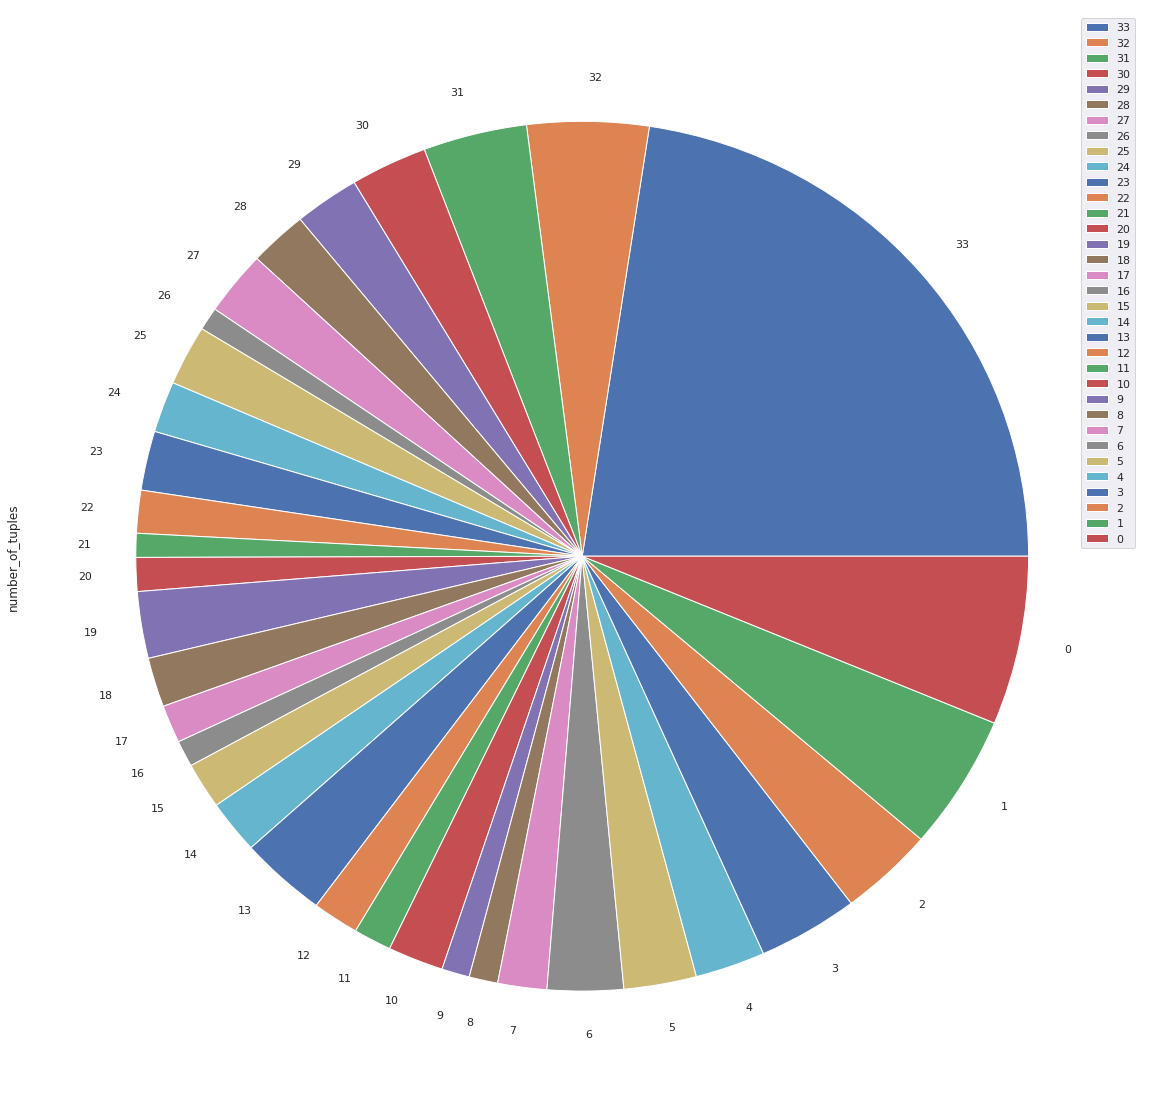

In [36]:
# count tuples by their number of date_int points
date_points = w_cat_ids.groupby(['shop_cat_tuple'])['date_counter'].unique().reset_index(name ='distinct_date_counters')
date_points['number_of_points'] = date_points.distinct_date_counters.apply(lambda x: len(x))

#date_points = date_points.shop_cat_tuple.unique()
date_points = date_points[['shop_cat_tuple', 'number_of_points']]

date_points = date_points.drop_duplicates()
date_points = date_points.groupby(['number_of_points'])['shop_cat_tuple'].count().reset_index(name ='number_of_tuples')

date_points = date_points.sort_values(by=['number_of_points'], ascending=False)
date_points

sns.set()

plot = date_points.plot.pie(y='number_of_tuples', figsize=(20, 20))

pred -599862.053514 3.57047358155 -331.481071562


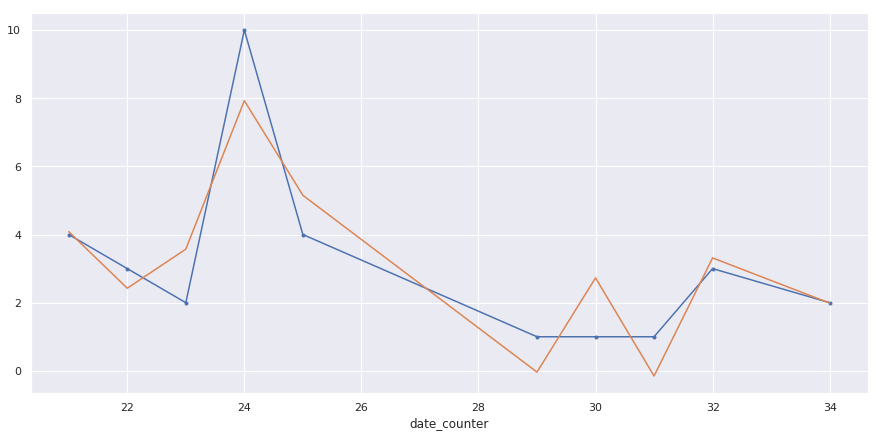

In [82]:
def get_tuple_for_number_of_points(num):
    points = w_cat_ids.groupby(['shop_cat_tuple'])['date_counter'].unique().reset_index(name ='distinct_date_counters')
    points['number_of_points'] = points.distinct_date_counters.apply(lambda x: len(x))
    return points[points.number_of_points == num].sample(1).shop_cat_tuple

poly_degree = 8

def plot_poly_for_shop_cat(shop_id, cat_id):
        shop = get_shop_w_one_cat(shop_id, cat_id)
        
        #shop = get_shop_w_all_cats(shop_id)


        datax = shop.date_counter.values
        datay = shop.item_cnt.values

        z = np.polyfit(datax,datay, poly_degree) 
        p = np.poly1d(z)

        shop['poly'] = shop['date_counter'].apply(lambda x: p(x))

        sns.set()
        fig, ax = plt.subplots()
        shop.plot(x='date_counter', y='item_cnt', ax=ax, legend=False, figsize=(15,7),style='.-')
        shop.plot(x='date_counter', y='poly', ax=ax, legend=False, figsize=(15,7))
        print("pred", p(11), p(23), p(35))
        
        
tup = get_tuple_for_number_of_points(10).get_values()[0]     

plot_poly_for_shop_cat(*tup)

In [77]:
date_points = w_cat_ids.groupby(['shop_cat_tuple'])['date_counter'].unique().reset_index(name ='distinct_date_counters')
date_points['number_of_points'] = date_points.distinct_date_counters.apply(lambda x: len(x))

w_cat_ids.head()

,shop_id,month,year,item_cnt_month,date_counter,item_name,item_category_id,shop_cat_tuple,item_cnt_global_mean,category_global_mean,item_mean_november
item_id,,,,,,,,,,,
0,54,9,2014,1.0,21,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"(54, 40)",1.0,1.886919,NaN
1,55,4,2014,2.0,16,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)",1.2,3.916089,NaN
1,55,7,2014,1.0,19,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)",1.2,3.916089,NaN
1,55,8,2014,1.0,20,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)",1.2,3.916089,NaN
1,55,9,2014,1.0,21,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)",1.2,3.916089,NaN


count    84.000000
mean     24.726190
std      12.003364
min       1.000000
25%      14.750000
50%      34.000000
75%      34.000000
max      34.000000
Name: number_of_points, dtype: float64

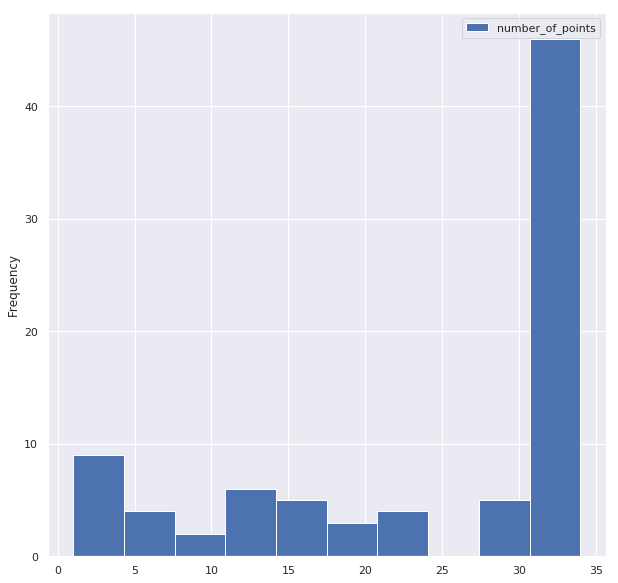

In [78]:
# count categories by their number of date_int points
date_points = w_cat_ids.groupby(['item_category_id'])['date_counter'].unique().reset_index(name ='distinct_date_counters')
date_points['number_of_points'] = date_points.distinct_date_counters.apply(lambda x: len(x))

#date_points = date_points.shop_cat_tuple.unique()
date_points = date_points[['item_category_id', 'number_of_points']]

plot = date_points.plot.hist(y='number_of_points', figsize=(10, 10))

date_points.number_of_points.describe()

count    6.200000e+01
mean     1.599922e+05
std      2.755428e+05
min      0.000000e+00
25%      5.628000e+03
50%      6.776700e+04
75%      1.895250e+05
max      1.552320e+06
Name: numbers_of_tuples, dtype: float64

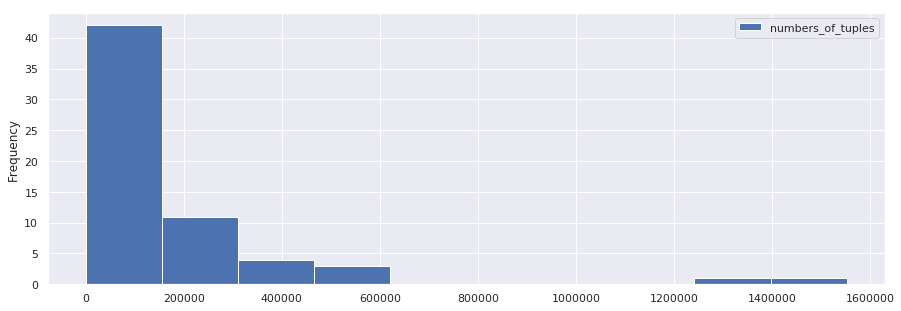

In [40]:
cats = test_w_cat_id.groupby(by=['item_category_id'])['item_category_id'].sum().reset_index(name ='numbers_of_tuples')

plot = cats.plot.hist(y='numbers_of_tuples', figsize=(15, 5))

cats.numbers_of_tuples.describe()

In [41]:
w_cat_ids.head()

,shop_id,month,year,item_cnt_month,date_counter,item_name,item_category_id,shop_cat_tuple
item_id,,,,,,,,
0,54,9,2014,1.0,21,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"(54, 40)"
1,55,4,2014,2.0,16,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,7,2014,1.0,19,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,8,2014,1.0,20,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,9,2014,1.0,21,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"


In [42]:
w_cat_ids.head()

,shop_id,month,year,item_cnt_month,date_counter,item_name,item_category_id,shop_cat_tuple
item_id,,,,,,,,
0,54,9,2014,1.0,21,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"(54, 40)"
1,55,4,2014,2.0,16,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,7,2014,1.0,19,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,8,2014,1.0,20,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"
1,55,9,2014,1.0,21,!ABBYY FineReader 12 Professional Edition Full...,76,"(55, 76)"


In [43]:
total_len = len(w_cat_ids)
for bt in [5,10,15,20,25,30]:
    res = len(w_cat_ids[w_cat_ids.date_counter < bt]) * 100 / total_len 
    print(bt, " : ", res)
w_cat_ids.date_counter.describe()

5  :  15.02519383217204
10  :  32.247235141604996
15  :  49.01722925020073
20  :  63.43712479585166
25  :  78.00946353419624
30  :  90.04856058327388


count    1.609124e+06
mean     1.566479e+01
std      9.542322e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.500000e+01
75%      2.400000e+01
max      3.400000e+01
Name: date_counter, dtype: float64

SyntaxError: unexpected EOF while parsing (<ipython-input-44-a3fd2afee17c>, line 2)

In [46]:
w_cat_ids['item_cnt_global_mean'] = w_cat_ids.groupby(w_cat_ids.index)['item_cnt_month'].transform(np.mean)
w_cat_ids['category_global_mean'] = w_cat_ids.groupby(w_cat_ids.item_category_id)['item_cnt_month'].transform(np.mean)






In [68]:
november = w_cat_ids[w_cat_ids.month == 11]

novembers = november.groupby(november.index)['item_cnt_month'].mean()

novembers = novembers.reindex(index=w_cat_ids.index)

w_cat_ids['item_mean_november'] = novembers


In [69]:
w_cat_ids.sample()

,shop_id,month,year,item_cnt_month,date_counter,item_name,item_category_id,shop_cat_tuple,item_cnt_global_mean,category_global_mean,item_mean_november
item_id,,,,,,,,,,,
6502,31,12,2014,1.0,24,"Sims 4 Limited Edition [PC, русская версия]",28,"(31, 28)",31.196429,3.916676,1.714286


In [74]:
w_cat_ids[w_cat_ids.year == 2014].groupby('month').size()

month
1     53320
2     47704
3     49291
4     44740
5     45766
6     46481
7     45756
8     46439
9     40423
10    42595
11    45755
12    59275
dtype: int64